In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-faces-object-detection/faces.csv
/kaggle/input/human-faces-object-detection/images/00002129.jpg
/kaggle/input/human-faces-object-detection/images/00001760.jpg
/kaggle/input/human-faces-object-detection/images/00001158.jpg
/kaggle/input/human-faces-object-detection/images/00001981.jpg
/kaggle/input/human-faces-object-detection/images/00000503.jpg
/kaggle/input/human-faces-object-detection/images/00001965.jpg
/kaggle/input/human-faces-object-detection/images/00001491.jpg
/kaggle/input/human-faces-object-detection/images/00001985.jpg
/kaggle/input/human-faces-object-detection/images/00002145.jpg
/kaggle/input/human-faces-object-detection/images/00000601.jpg
/kaggle/input/human-faces-object-detection/images/00001179.jpg
/kaggle/input/human-faces-object-detection/images/00003048.jpg
/kaggle/input/human-faces-object-detection/images/00003437.jpg
/kaggle/input/human-faces-object-detection/images/00000848.jpg
/kaggle/input/human-faces-object-detection/images/00000567.jpg
/k

# Human Face Detection using a Convolutional Neural Network

## Importing required libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import pathlib
import PIL
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense,Dropout, BatchNormalization

## Visualising the data

In [3]:
dataset = pd.read_csv('/kaggle/input/human-faces-object-detection/faces.csv')

In [4]:
dataset.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [5]:
data = {}
for i in dataset["image_name"]:
    if i not in data:
        data[i] = []
for index, img_name in enumerate(dataset["image_name"]):
    width = dataset["width"][index]
    height = dataset["height"][index]
    x0 = dataset["x0"][index]
    x1 = dataset["x1"][index]
    y0 = dataset["y0"][index]
    y1 = dataset["y1"][index]
    
    new_x0 = int((x0/width)*224)
    new_x1 = int((x1/width)*224)
    new_y0 = int((y0/width)*224)
    new_y1 = int((y1/width)*224)
    
    data[img_name].append(new_x0)
    data[img_name].append(new_x1)
    data[img_name].append(new_y0)
    data[img_name].append(new_y1)

In [6]:
ls ../input/human-faces-object-detection/images/

00000003.jpg  00000899.jpg  00001547.jpg  00002101.jpg  00002836.jpg
00000004.jpg  00000900.jpg  00001548.jpg  00002102.jpg  00002837.jpg
00000005.jpg  00000901.jpg  00001549.jpg  00002103.jpg  00002839.jpg
00000006.jpg  00000902.jpg  00001550.jpg  00002105.jpg  00002841.jpg
00000008.jpg  00000903.jpg  00001551.jpg  00002106.jpg  00002842.jpg
00000011.jpg  00000908.jpg  00001552.jpg  00002110.jpg  00002843.jpg
00000012.jpg  00000910.jpg  00001554.jpg  00002111.jpg  00002845.jpg
00000015.jpg  00000913.jpg  00001555.jpg  00002113.jpg  00002846.jpg
00000018.jpg  00000916.jpg  00001556.jpg  00002114.jpg  00002847.jpg
00000020.jpg  00000917.jpg  00001557.jpg  00002115.jpg  00002848.jpg
00000022.jpg  00000920.jpg  00001558.jpg  00002116.jpg  00002850.jpg
00000023.jpg  00000921.jpg  00001560.jpg  00002117.jpg  00002851.jpg
00000024.jpg  00000923.jpg  00001561.jpg  00002118.jpg  00002852.jpg
00000026.jpg  00000924.jpg  00001562.jpg  00002119.jpg  00002853.jpg
00000031.jpg  00000926.jpg  000015

In [7]:
for dirpath, dirnames, filenames in os.walk("../input"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '../input'.
There are 1 directories and 1 images in '../input/human-faces-object-detection'.
There are 0 directories and 2204 images in '../input/human-faces-object-detection/images'.


In [8]:
img_dir = os.listdir('../input/human-faces-object-detection/images')
images = []
for img_name in data.keys():
    for itr in img_dir:
        if img_name == itr:
            img_arr = cv.imread(os.path.join('../input/human-faces-object-detection/images', img_name),
                               cv.IMREAD_GRAYSCALE)
            img_resize = cv.resize(img_arr, (224, 224))
            images.append(img_resize)

In [9]:
images = np.array(images)
images = np.expand_dims(images, axis = 3)

In [10]:
print(f"Shape of images : {images.shape}")

Shape of images : (2204, 224, 224, 1)


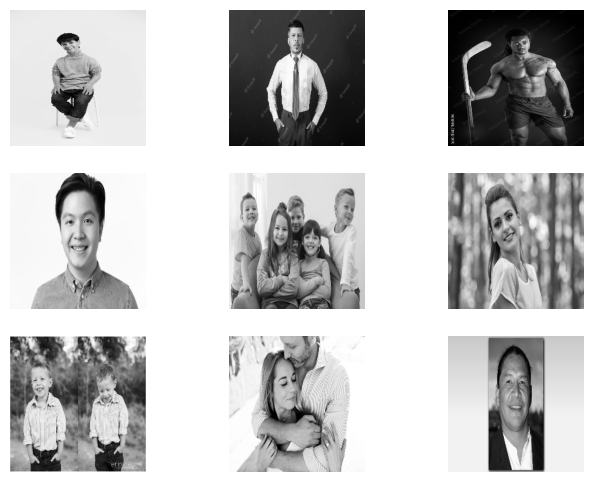

In [11]:
plt.figure(figsize = (8,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.axis('off')

## Creating BBoxes (or Bounding Boxes) for Object Detection

In [12]:
bbox = []
for box in data.keys():
    bbox.append(data[box])

In [13]:
max_bbox = 0
for i in range(len(bbox)):
    max_bbox = max(max_bbox, len(bbox[i]))

In [14]:
for i in range(len(bbox)):
    if int(max_bbox) - len(bbox[i]) != 0:
        for j in range(int(max_bbox) - len(bbox[i])):
            bbox[i].append(0)

In [15]:
bbox = np.array(bbox)
bbox[0]

array([ 82, 115,  53, 111,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [16]:
bbox.shape

(2204, 48)

## Normalisation of image data and bboxes

In [17]:
images = images/255
bbox = bbox/224

## Splitting the data into training and test sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images, bbox, test_size = 0.25, random_state = 42)

## Building a CNN Sequential Model

In [19]:
model = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(64, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(128, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(256, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer has 48 neurons to match the bbox dimensions
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [21]:
#Adapted from the PyImageSearch article on Object Detection with Keras and TensorFlow
#https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/

class obj_detect_callback(keras.callbacks.Callback):
    def epoch_end(self, epoch, logs = {}):
        prediction = model.predict(X_test[0].reshape(1,224,224,1))
        fig, ax = plt.subplots(1)
        ax.imshow(X_test[0])
        x1 = int(prediction[0][0]*224)
        y1 = int(prediction[0][1]*224)
        x2 = int(prediction[0][2]*224)
        y2 = int(prediction[0][3]*224)
        rect = matplotlib.patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
        plt.show()

In [22]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['accuracy'])

In [23]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), epochs = 50, callbacks = [obj_detect_callback()])

Epoch 1/50
52/52 [==============================] - 20s 82ms/step - loss: 0.2434 - accuracy: 0.4912 - val_loss: 0.1278 - val_accuracy: 0.6806
Epoch 2/50
52/52 [==============================] - 3s 53ms/step - loss: 0.1241 - accuracy: 0.6854 - val_loss: 0.1265 - val_accuracy: 0.6806
Epoch 3/50
52/52 [==============================] - 3s 53ms/step - loss: 0.1239 - accuracy: 0.6661 - val_loss: 0.1282 - val_accuracy: 0.6806
Epoch 4/50
52/52 [==============================] - 3s 53ms/step - loss: 0.1225 - accuracy: 0.6854 - val_loss: 0.1260 - val_accuracy: 0.6806
Epoch 5/50
52/52 [==============================] - 3s 53ms/step - loss: 0.1222 - accuracy: 0.6697 - val_loss: 0.1229 - val_accuracy: 0.6806
Epoch 6/50
52/52 [==============================] - 3s 53ms/step - loss: 0.1217 - accuracy: 0.6836 - val_loss: 0.1238 - val_accuracy: 0.6806
Epoch 7/50
52/52 [==============================] - 3s 57ms/step - loss: 0.1200 - accuracy: 0.6830 - val_loss: 0.1231 - val_accuracy: 0.6806
Epoch 8/50
5

In [24]:
# Adapted from Daniel Bourke's Course on TensorFlow and Deep Learning
def plot_loss_curves(history):
  '''
  Returns separate loss curves for training and validation metrics
  '''
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  
  epochs = range(len(history.history['loss'])) #generates the sequence of indices in a list, in this case epochs

  #Plot loss
  plt.plot(epochs, loss, label = 'training loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

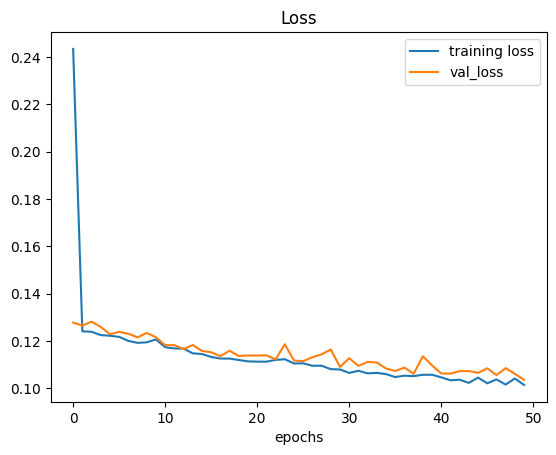

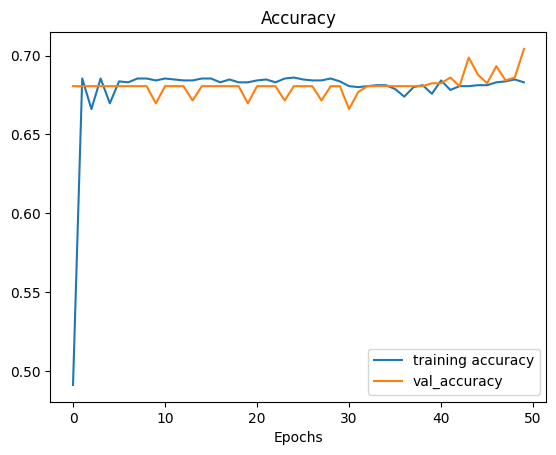

In [25]:
plot_loss_curves(history)

In [26]:
model.evaluate(X_test, y_test, batch_size = 32)

18/18 [==============================] - 0s 19ms/step - loss: 0.1036 - accuracy: 0.7042


[0.10356821119785309, 0.7041742205619812]

## Model 2: Adding a BatchNormalisation and Dropout Layer

The Dropout Layer will set input unit frequencies to 0 at any point during training. Overfitting is thus prevented.

In [27]:
model_2 = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    Dropout(0.2),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    Dropout(0.3),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(256, 3, activation = 'relu'),
    Dropout(0.4),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer
])

In [28]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)     

In [29]:
model_2.compile(loss = 'binary_crossentropy',
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [30]:
history_2 = model_2.fit(X_train, y_train, validation_data = (X_test, y_test),
           batch_size = 8, epochs = 60, callbacks = [obj_detect_callback()])

Epoch 1/60


2023-05-04 10:17:57.447871: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


207/207 [==============================] - 12s 38ms/step - loss: 0.1547 - accuracy: 0.6431 - val_loss: 0.1849 - val_accuracy: 0.6806
Epoch 2/60
207/207 [==============================] - 7s 33ms/step - loss: 0.1171 - accuracy: 0.6618 - val_loss: 0.1590 - val_accuracy: 0.6806
Epoch 3/60
207/207 [==============================] - 7s 34ms/step - loss: 0.1137 - accuracy: 0.6667 - val_loss: 0.1492 - val_accuracy: 0.6806
Epoch 4/60
207/207 [==============================] - 7s 33ms/step - loss: 0.1101 - accuracy: 0.6703 - val_loss: 0.1464 - val_accuracy: 0.6806
Epoch 5/60
207/207 [==============================] - 7s 33ms/step - loss: 0.1102 - accuracy: 0.6794 - val_loss: 0.1545 - val_accuracy: 0.6751
Epoch 6/60
207/207 [==============================] - 7s 34ms/step - loss: 0.1093 - accuracy: 0.6673 - val_loss: 0.1220 - val_accuracy: 0.6860
Epoch 7/60
207/207 [==============================] - 7s 35ms/step - loss: 0.1084 - accuracy: 0.6630 - val_loss: 0.1339 - val_accuracy: 0.6806
Epoch 8/6

Slight improvement in the accuracy over the previous model.

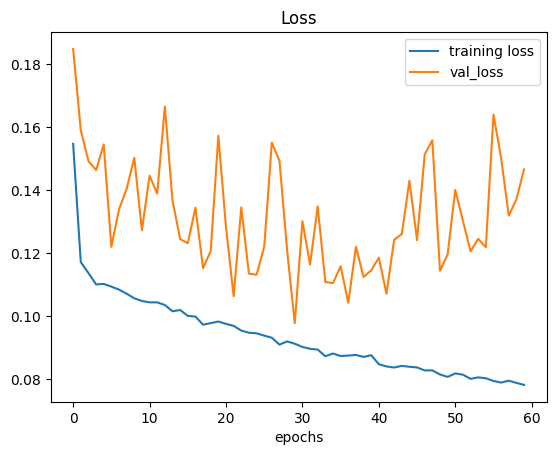

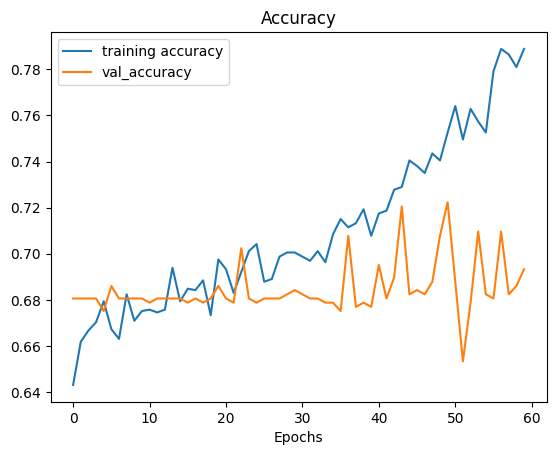

In [31]:
plot_loss_curves(history_2)

In [32]:
model_2.evaluate(X_test, y_test, batch_size = 32)

18/18 [==============================] - 1s 16ms/step - loss: 0.1466 - accuracy: 0.6933


[0.14658348262310028, 0.6932849287986755]

In [33]:
def plot_predictions(model,idx):
    '''
    Plots the decision boundary for a model on an image specified by its index.
    
    Parameters:
    
    model: The model whose predictions we are testing
    idx: The index of the image as it appears in the dataset
    '''
    model_prediction = model.predict(X_test[idx].reshape(1, 224, 224, 1))
    model_prediction = model_prediction[0]
    img = X_test[idx]
    count = 0
    bbox1 = []
    for i in model_prediction:
        bbox1.append(i)
        count+=1
        if count == 4:
            count = 0
            plt.subplot(1,2,1)
            plt.imshow(img)
            x1 = int(bbox1[0]*224)
            y1 = int(bbox1[1]*224)
            x2 = int(bbox1[2]*224)
            y2 = int(bbox1[3]*224)
            plt.gca().add_patch(matplotlib.patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1,
                                                 edgecolor = 'r', facecolor = "none"))
            bbox1 = []
    plt.show()

1/1 [==============================] - 0s 302ms/step


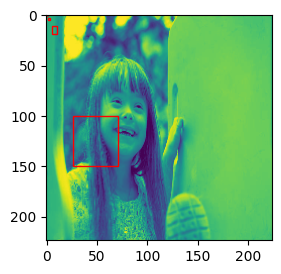

In [34]:
plot_predictions(model,4)

1/1 [==============================] - 0s 271ms/step


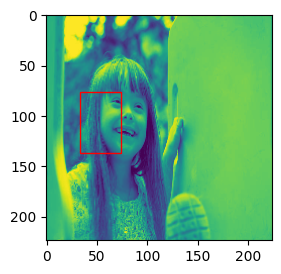

In [35]:
plot_predictions(model_2, 4)